 * In this project I am going to predict the price of used cars using Random Forest, Linear regression, Lasso and Ridge            regression and Decision tree
 * Data is collected from Kaggle.
 * I used python for Data cleaning, Data pre-processing, seaborn and Matplotlib for Visualisation, Scikit learn for building       the machine learning models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data = pd.read_csv('craigslistVehicles.csv')

In [3]:
data.head()

,url,city,city_url,price,year,manufacturer,make,condition,cylinders,fuel,...,transmission,VIN,drive,size,type,paint_color,image_url,desc,lat,long
0,https://abilene.craigslist.org/cto/d/aspermont...,"abilene, TX",https://abilene.craigslist.org,9000,2009.0,chevrolet,suburban lt2,good,8 cylinders,gas,...,automatic,1GFNC26099R211276,rwd,full-size,SUV,white,https://images.craigslist.org/00909_5P6f1E6zHl...,2WD 1/2 ton\nLeather Captains Chairs\nIn good ...,33.130100,-100.234400
1,https://abilene.craigslist.org/ctd/d/liberty-h...,"abilene, TX",https://abilene.craigslist.org,31999,2012.0,ram,2500,NaN,NaN,diesel,...,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00u0u_24XW8uhLYP...,www.GETADIESEL.com\n2012 RAM 2500 SLT 4X4 MEGA...,30.648368,-97.862949
2,https://abilene.craigslist.org/ctd/d/liberty-h...,"abilene, TX",https://abilene.craigslist.org,16990,2003.0,ram,3500,NaN,NaN,diesel,...,manual,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00l0l_H1UKTJ4sTI...,www.GETADIESEL.com\n2003 DODGE RAM 3500 LARAMI...,30.648516,-97.862434
3,https://abilene.craigslist.org/cto/d/merkel-20...,"abilene, TX",https://abilene.craigslist.org,6000,2002.0,gmc,sierra 1500,good,8 cylinders,gas,...,automatic,NaN,4wd,NaN,pickup,white,https://images.craigslist.org/00M0M_2wKzc7dKLU...,2002 GMC Sierra Extended Cab Truck For Sale! R...,32.444400,-99.992400
4,https://abilene.craigslist.org/cto/d/breckenri...,"abilene, TX",https://abilene.craigslist.org,37000,2012.0,chevrolet,3500,excellent,8 cylinders,diesel,...,automatic,NaN,4wd,full-size,pickup,silver,https://images.craigslist.org/00r0r_eW1YWlKfCG...,"2012 Chevrolet 3500 178k miles, runs and drive...",32.781689,-98.942248


In [4]:
data.shape

(550313, 22)

In [5]:
# copy
new_data = data.copy()

In [6]:
new_data.shape

(550313, 22)

## **Data Cleaning**

In [7]:
#re-naming the columns
new_data.rename({'make': 'model', 'odometer': 'mileage'}, axis= 1,inplace= True)

In [8]:
# Lets drop the columns that are not useful for the car price prediction.
drop_columns = ['city_url', 'url','lat','long','image_url', 'VIN', 'city']
new_data = new_data.drop(drop_columns, axis =1)
new_data.shape

(550313, 15)

In [9]:
#lets drop the columns where price of the car is more than 2.5 million dollars because high end used cars like ferrari, porsche costs less than that
new_data = new_data.drop(new_data[new_data.price > 250000].index)
new_data.shape

(550177, 15)

In [10]:
#Lets drop the columns where year is less than 1990 and greater than 2019
new_data = new_data[(new_data['year'] > 1990) & (new_data['year'] < 2020)]
new_data.index = range(len(new_data))
new_data.shape

(527135, 15)

In [11]:
# finding the length of description of each car
new_data.dropna(subset = ['desc'],inplace = True) # dropping the null values in 'desc' column
new_data['word_len'] = new_data.desc.apply(lambda x: len(str(x.lower().split())))
new_data.index = range(len(new_data))
del new_data['desc']

In [12]:
#finding the age of car
from datetime import datetime

current_year = datetime.now().year
new_data['Age'] = current_year - new_data['year']
del new_data['year']

In [13]:
# removing the 'cylinders' in the columns and converting into float.
new_data.cylinders = new_data.cylinders.apply(lambda x: x if str(x).lower()[-1] == 'o' or str(x).lower()[-1] == 'n' else str(x).lower().replace('cylinders', ''))
new_data.cylinders = pd.to_numeric(new_data.cylinders, errors = 'coerce')
new_data.cylinders.fillna(new_data.cylinders.median(), inplace = True)

In [14]:
# Lets drop the rows where has atleast 3 NaN values.
new_data.dropna(thresh = 13, axis = 0, inplace = True)
new_data.shape

(324833, 15)

In [15]:
#dropping the duplicates in the data
new_data.drop_duplicates(keep = 'first', inplace = True)
new_data.index = range(len(new_data))
new_data.shape

(251722, 15)

In [16]:
# fixing the spelling errors
new_data.manufacturer = new_data.manufacturer.apply(lambda x: x.replace('porche', 'porsche') if x == 'porche' else x)

In [17]:
# creating new dataframe to find the size of each car in order to fill the null values in the size feature of same car
new = new_data.sort_values(by= ['size','manufacturer','type'])
new.drop_duplicates(subset = ['model','type'], keep = 'first', inplace = True)
new.index = range(len(new))

In [18]:
new.dropna(subset = ['size','model'], inplace= True)
new.index = range(len(new))

In [19]:
# dictionary that contain size of each car
size = dict(zip(new['model'], new['size']))
for i in range(len(new_data)):
    if str(new_data['size'][i]).lower()[0] == 'n' and (new_data['model'][i] in size.keys()):
        new_data['size'][i] = size[new_data['model'][i]]

C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
# Adding the manufacturers name to list from the dataset and adding few more manufacturer after looking the make column in dataset
manuf = []
for i in new_data.manufacturer.value_counts().index:
    manuf.append(i)
manuf.append('Tesla')
manuf.append('Rolls-Royce')
manuf.append('genesis')

In [21]:
# Replace the nan values in the manufacturer column based on the model column 
# from make column we can identify manufacturer of the car as it sometimes contains the manufacturer name in it
d = new_data['manufacturer']
m = new_data['model']
for i in range(len(new_data)):
    if str(d[i]).lower()[0] == 'n':
        for x in str(m[i]).lower().split():
            for mm in manuf:
                if (len(x) > 4) & (x[:4] == mm.lower()[:4]):
                    new_data['manufacturer'][i] = mm
                elif (x[:3] == mm.lower()[:3]) & (x[:-1] == mm.lower()[:-1]):
                    new_data['manufacturer'][i] = mm

C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [46]:
# # reduce the paint color feature to common and not common colors
# common_colors = list(['white','grey','black','silver','blue','red'])
# new_data['paint_color'] = new_data['paint_color'].apply(lambda x: 'Common' if x in common_colors else 'Not_common')

In [22]:
#dropping the null values
new_data.dropna(subset = ['transmission','type','manufacturer','model','fuel','mileage','title_status','paint_color','drive','size','condition'],inplace = True)
new_data.index = range(len(new_data))
new_data.shape

(124536, 15)

In [23]:
# Function to remove the outliers in the data
def outlier_removal(x):
    for i in x:
        z_score_od = np.abs(stats.zscore(new_data[i]))
        outliers = np.where(z_score_od > 3)
        new_data.drop(new_data.index[[i for i in outliers[0]]],inplace= True)
        new_data.index = range(len(new_data))  
        
outlier_removal(new_data._get_numeric_data().columns)

In [24]:
# price of car cant be zero so we are eliminating the price less than 50 dollars. Some people mention very less price and 
# they will reveal the price directly to customer while buying and bargain later.
new_data = new_data[new_data['price'] > 50]
new_data.index = range(len(new_data))
new_data.shape

(114180, 15)

In [25]:
#shifting the 'age' to new place
new_data.insert(1, 'age', new_data['Age'])
del new_data['Age']

In [26]:
# # creating the dictionary for integer labelling
# cond_dict = {'new':10, 'like new':9, 'excellent':8, 'good':7, 'fair':5, 'salvage':3}
# title_dict = {'clean': 6, 'lien': 4, 'rebuilt':3, 'salvage': 2, 'parts only': 1, 'missing': 0}
# columns = list(['condition', 'title_status'])
# dictionary = list([cond_dict, title_dict])

# #Function that does the integer labelling.
# def labelling(columns, dictionary):
#     for i in range(len(columns)):
#         new_data[columns[i]] = new_data[columns[i]].map(dictionary[i])

# labelling(columns, dictionary)

In [27]:
new_data.columns

Index(['price', 'age', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'mileage', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'word_len'],
      dtype='object')

In [31]:
new_data.condition.value_counts()

excellent    53316
good         43039
new          12042
fair          5378
salvage        405
Name: condition, dtype: int64

In [29]:
new_data.title_status.value_counts()

clean         106684
rebuilt         3703
lien            1934
salvage         1752
missing           75
parts only        32
Name: title_status, dtype: int64

In [30]:
# changing the 'like new' to 'new'
new_data.condition = new_data.condition.apply(lambda x: x.replace('like new', 'new') if x == 'like new' else x)

In [32]:
# Finding the models of car which has fewer data
other_models = new_data.model.value_counts().index[new_data.model.value_counts().values < 5]

In [33]:
# Function replaces the less frequent models of car to other_models category
def model_edit(model_list, data):
    for i in range(len(data)):
        if data[i] in model_list:
            data[i] = 'other_models'

model_edit(other_models, new_data['model'])

C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [34]:
# changing the datatype from float to int
new_data['age'] = new_data['age'].astype(int)
new_data['mileage'] = new_data['mileage'].astype(int)
new_data['cylinders'] = new_data['cylinders'].astype(int)

In [35]:
new_data.head()

,price,age,manufacturer,model,condition,cylinders,fuel,mileage,title_status,transmission,drive,size,type,paint_color,word_len
0,9000,11,chevrolet,other_models,good,8,gas,217743,clean,automatic,rwd,full-size,SUV,white,132
1,6000,18,gmc,sierra 1500,good,8,gas,195000,clean,automatic,4wd,full-size,pickup,white,505
2,37000,8,chevrolet,3500,excellent,8,diesel,178000,clean,automatic,4wd,full-size,pickup,silver,274
3,9700,10,cadillac,srx luxury collection,good,8,gas,140000,clean,automatic,fwd,mid-size,SUV,white,483
4,2500,19,chevrolet,silverado 1500,fair,8,gas,220000,clean,automatic,rwd,full-size,pickup,silver,3657


In [36]:
new_data.dtypes

price            int64
age              int32
manufacturer    object
model           object
condition       object
cylinders        int32
fuel            object
mileage          int32
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
word_len         int64
dtype: object

In [37]:
new_data.isnull().sum() # Now data is clean and it has no null values

price           0
age             0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
mileage         0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
word_len        0
dtype: int64

In [38]:
new_data.describe(include= 'all')

,price,age,manufacturer,model,condition,cylinders,fuel,mileage,title_status,transmission,drive,size,type,paint_color,word_len
count,114180.000000,114180.000000,114180,114180,114180,114180.000000,114180,114180.000000,114180,114180,114180,114180,114180,114180,114180.000000
unique,NaN,NaN,42,2574,5,NaN,5,NaN,6,3,3,4,13,12,NaN
top,NaN,NaN,ford,other_models,excellent,NaN,gas,NaN,clean,automatic,4wd,full-size,sedan,white,NaN
freq,NaN,NaN,20977,13584,53316,NaN,105387,NaN,106684,103661,46905,60146,32570,25028,NaN
mean,10475.529865,11.273883,NaN,NaN,NaN,5.935645,NaN,117485.298634,NaN,NaN,NaN,NaN,NaN,NaN,1685.352347
std,8148.561698,5.617062,NaN,NaN,NaN,1.536442,NaN,62421.126557,NaN,NaN,NaN,NaN,NaN,NaN,2003.263764
min,52.000000,1.000000,NaN,NaN,NaN,3.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
25%,4400.000000,7.000000,NaN,NaN,NaN,4.000000,NaN,73197.000000,NaN,NaN,NaN,NaN,NaN,NaN,399.000000
50%,7995.000000,11.000000,NaN,NaN,NaN,6.000000,NaN,115397.500000,NaN,NaN,NaN,NaN,NaN,NaN,840.000000
75%,14500.000000,15.000000,NaN,NaN,NaN,8.000000,NaN,157900.000000,NaN,NaN,NaN,NaN,NaN,NaN,2027.000000


In [39]:
#saving the cleaned data to new csv file
new_data.to_csv('Final_data1', index= False)

In [2]:
Final_data = pd.read_csv('Final_data1')

In [41]:
def unique_val(data, columns):
    unique = []
    for col in columns:
        u = data[col].nunique()
        unique.append((col,u,data[col].value_counts(normalize=True).values[0] * 100))
    return unique

In [42]:
unique = unique_val(Final_data, Final_data.columns)

In [43]:
unique_values = pd.DataFrame(unique, columns = ['Features','unique_values','Largest category percentage']).sort_values('Largest category percentage',ascending = False)
unique_values

,Features,unique_values,Largest category percentage
8,title_status,6,93.434927
6,fuel,5,92.299002
9,transmission,3,90.787353
11,size,4,52.676476
4,condition,5,46.694693
5,cylinders,6,41.628131
10,drive,3,41.079874
12,type,13,28.525136
13,paint_color,12,21.919776
2,manufacturer,42,18.371869


In [44]:
imbalanced_columns = unique_values[unique_values['Largest category percentage'] > 80.0]
imbalanced_columns

,Features,unique_values,Largest category percentage
8,title_status,6,93.434927
6,fuel,5,92.299002
9,transmission,3,90.787353


In [45]:
#dropping the imbalanced columns which has one category that holds most of values in the feature.
Final_data1 = Final_data.drop(columns = imbalanced_columns.Features)

In [46]:
Final_data1.shape

(114180, 12)

In [47]:
Final_data1.columns

Index(['price', 'age', 'manufacturer', 'model', 'condition', 'cylinders',
       'mileage', 'drive', 'size', 'type', 'paint_color', 'word_len'],
      dtype='object')

## **Visualization**

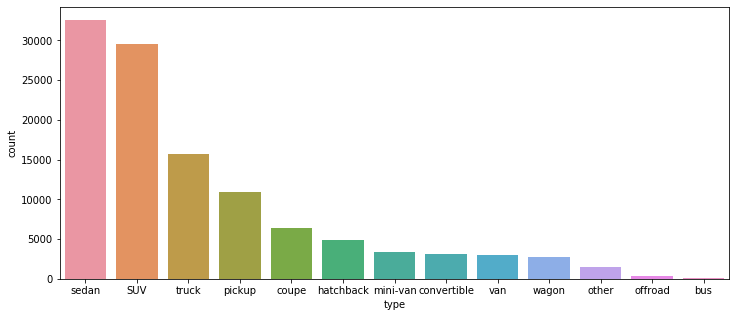

In [48]:
plt.figure(figsize = (12,5))
sns.countplot(x = 'type', order = Final_data['type'].value_counts().index, data = Final_data)

__People are selling the used Sedan the most followed by SUV and Trucks. They are very less likely to sell Bus and off-road vehicles because customer dont buy those often.__

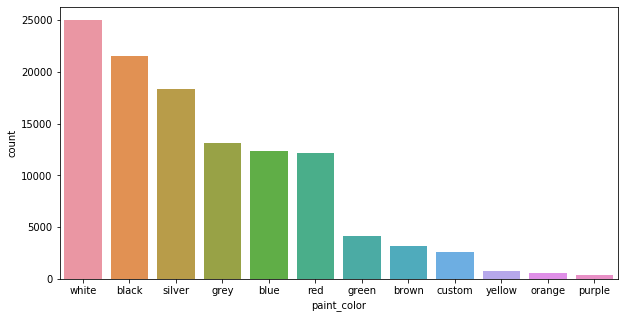

In [49]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'paint_color', order = Final_data['paint_color'].value_counts().index,data = Final_data)

1. __We can see that people are buying used cars with common colors(white,grey,black,silver,blue,red) than not common colors__
2. __Not Common colors (purple, orange, green etc) are mostly luxury cars which are too expensive__

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

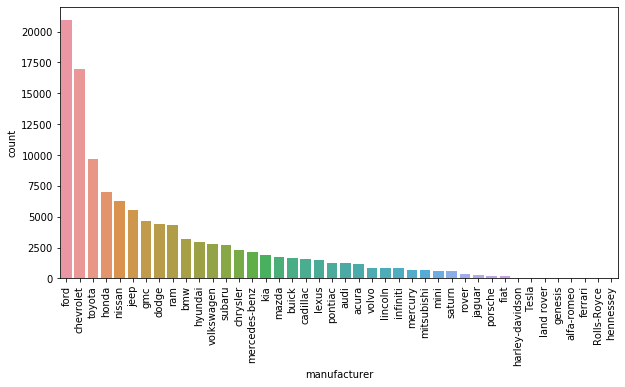

In [50]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'manufacturer', order = Final_data['manufacturer'].value_counts().index, data = Final_data)
plt.xticks(rotation = 90)

__Ford, Toyota, Chevrolet and Honda__ manufacturer cover most of the used cars because they are cheap and good than other manufacturers like __Ferrari, Rolls-Royce and Hennessey__

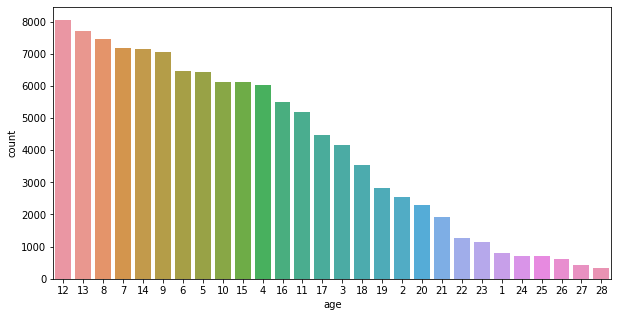

In [51]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'age', order = Final_data['age'].value_counts().index, data = Final_data)

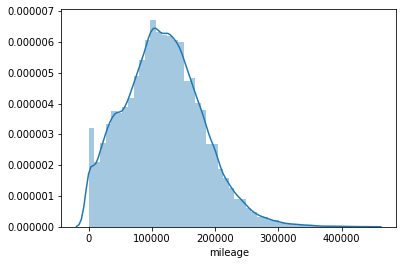

In [52]:
sns.distplot(Final_data['mileage'])

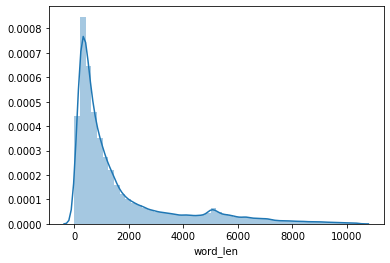

In [53]:
sns.distplot(Final_data['word_len'])

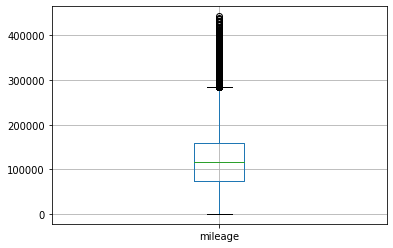

In [54]:
Final_data.boxplot('mileage')

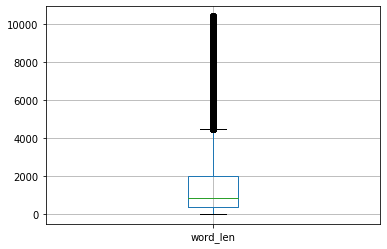

In [55]:
Final_data.boxplot('word_len')

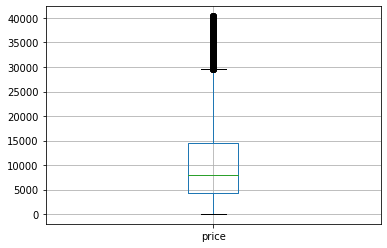

In [56]:
Final_data.boxplot('price')

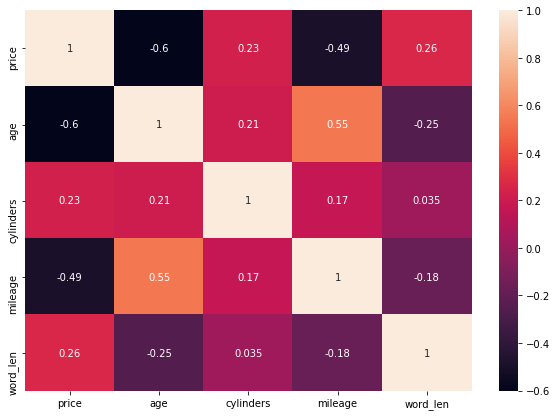

In [57]:
plt.figure(figsize = (10,7))
corr = Final_data.corr()
sns.heatmap(corr, annot = True)

## **Model building**

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization

In [5]:
F1 = pd.get_dummies(Final_data)
F1.head()

,price,age,cylinders,mileage,word_len,manufacturer_Rolls-Royce,manufacturer_Tesla,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_audi,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,9000,11,8,217743,132,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6000,18,8,195000,505,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,37000,8,8,178000,274,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9700,10,8,140000,483,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2500,19,8,220000,3657,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [61]:
X = F1.drop('price',axis = 1)
y = F1['price']

In [219]:
# # scaling the inputs
# scaler = MinMaxScaler().fit(X)
# X = scaler.transform(X)

In [62]:
X = X.values
X

array([[    11,      8, 217743, ...,      0,      1,      0],
       [    18,      8, 195000, ...,      0,      1,      0],
       [     8,      8, 178000, ...,      1,      0,      0],
       ...,
       [    17,      6, 122953, ...,      0,      0,      0],
       [    17,      6, 142779, ...,      0,      0,      0],
       [    19,      8, 205000, ...,      1,      0,      0]], dtype=int64)

In [63]:
y = y.values.ravel()
y

array([ 9000,  6000, 37000, ...,  2950,  2350,  2200], dtype=int64)

In [64]:
print(X.shape)
print(y.shape)

(114180, 2671)
(114180,)


In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [66]:
# Algorithms
linreg = LinearRegression()
lasso = Lasso()
ridge = Ridge()
Dtree = DecisionTreeRegressor()
rfreg = RandomForestRegressor()

In [70]:
# parameters
kfold = KFold(n_splits = 5)
scoring = 'r2'
algo_list = list([linreg,lasso,ridge,Dtree,rfreg])
algo_name = list(['Linear regression','lasso','ridge','Decision tree','Random Forest'])

In [77]:
# Buliding models on various algorithms
def model_building(algo,X,y,fold,scoring):
    algo_score = []
    for i in algo:
        score = cross_val_score(i, X, y, cv=fold, scoring=scoring).mean()
        algo_score.append(score)
    return algo_score

In [78]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-06-20 00:23:41.807546


In [79]:
result = model_building(algo_list, X_train, y_train, kfold, scoring)

C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

In [80]:
cv_score = dict(zip(algo_name,result))

In [82]:
cv_score

{'Linear regression': -3.219153162094839e+20,
 'lasso': 0.733601291024901,
 'ridge': 0.7608259838484435,
 'Decision tree': 0.7336919057925986,
 'Random Forest': 0.8478481386440171,
 'Gradient Boosting': 0.7983221032791225}

# Hyperparameter tuning

In [84]:
def RF_optimizer(bootstrap,min_samples_leaf,n_estimators):
    algo_performance = []
    m=RandomForestRegressor(bootstrap=bootstrap,min_samples_leaf=int(round(min_samples_leaf)),n_estimators=int(round(n_estimators)))
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [85]:
def GBM_optimizer(learning_rate,max_depth,n_estimators,min_samples_split):
    algo_performance = []
    
    m=GradientBoostingRegressor(learning_rate=learning_rate,max_depth=int(round(max_depth)),n_estimators=int(round(n_estimators)),min_samples_split=int(round(min_samples_split)))    
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [175]:
def lasso_optimizer(alpha):
    algo_performance = []
    m=Lasso(alpha = alpha)
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [176]:
def ridge_optimizer(alpha):
    algo_performance = []
    m=Ridge(alpha = alpha)
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [86]:
GBM_bounds={'learning_rate':(0.08,0.12),'max_depth':(1,5),'n_estimators':(70,130),'min_samples_split':(2,4)}
RF_bounds={'bootstrap':(True,False),'min_samples_leaf':(1,20),'n_estimators':(100,200)}

In [172]:
lasso_params = {'alpha':(0.005, 0.06)}
ridge_params = {'alpha':(550,650)}

In [173]:
optimizers=[RF_optimizer,GBM_optimizer]
bounds=[RF_bounds,GBM_bounds]

In [174]:
optimizers1=[lasso_optimizer,ridge_optimizer]
bounds1=[lasso_params,ridge_params]

In [96]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-06-20 03:23:22.127008


In [97]:
def tuning(optimizers,bounds):
    hyperparameter={}
    for i in range(len(optimizers)):
        print(optimizers[i].__name__)
        temp=BayesianOptimization(f=optimizers[i],pbounds=bounds[i],random_state=1)
        temp.maximize(n_iter= 5)
        hyperparameter[optimizers[i]]=temp.max
    return hyperparameter

tuning(optimizers,bounds)

RF_optimizer
|   iter    |  target   | bootstrap | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8207   |  0.583    |  14.69    |  100.0    |
|  2        |  0.8409   |  0.6977   |  3.788    |  109.2    |
|  3        |  0.8308   |  0.8137   |  7.566    |  139.7    |
|  4        |  0.8289   |  0.4612   |  8.965    |  168.5    |
|  5        |  0.8174   |  0.7955   |  17.68    |  102.7    |
|  6        |  0.7653   |  0.0      |  1.17     |  198.7    |
|  7        |  0.7901   |  0.0      |  19.89    |  196.6    |
|  8        |  0.7651   |  0.0      |  1.082    |  101.1    |
|  9        |  0.7901   |  0.0      |  19.89    |  154.5    |
|  10       |  0.7653   |  0.0      |  1.02     |  126.0    |
GBM_optimizer
|   iter    |  target   | learni... | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.8126   |  0.09668  |  3.881    |  2.0      |  88.14    |
|  2   

{<function __main__.RF_optimizer(bootstrap, min_samples_leaf, n_estimators)>: {'target': 0.8408675391975569,
  'params': {'bootstrap': 0.6976674273681602,
   'min_samples_leaf': 3.7883619255251477,
   'n_estimators': 109.23385947687979}},
 <function __main__.GBM_optimizer(learning_rate, max_depth, n_estimators, min_samples_split)>: {'target': 0.8359832126492405,
  'params': {'learning_rate': 0.12,
   'max_depth': 5.0,
   'min_samples_split': 2.0,
   'n_estimators': 130.0}}}

In [194]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-06-20 16:58:19.581883


In [195]:
def tuning1(optimizers,bounds):
    hyperparameter={}
    for i in range(len(optimizers)):
        print(optimizers[i].__name__)
        temp=BayesianOptimization(f=optimizers[i],pbounds=bounds[i],random_state=1)
        temp.maximize(n_iter= 15)
        hyperparameter[optimizers[i]]=temp.max
    return hyperparameter

In [196]:
tuning1(optimizers1,bounds1)

lasso_optimizer
|   iter    |  target   |   alpha   |
-------------------------------------


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395783758099.6956, tolerance: 558780486.997039
  positive)


|  1        |  0.7618   |  0.02794  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252297678504.8816, tolerance: 558780486.997039
  positive)


|  2        |  0.7617   |  0.04462  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593628864988.8098, tolerance: 558780486.997039
  positive)


|  3        |  0.7613   |  0.005006 |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460006129352.1068, tolerance: 558780486.997039
  positive)


|  4        |  0.7617   |  0.02163  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534920623966.93726, tolerance: 558780486.997039
  positive)


|  5        |  0.7616   |  0.01307  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121137689286.48755, tolerance: 558780486.997039
  positive)


|  6        |  0.7614   |  0.05846  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519419341171.1446, tolerance: 558780486.997039
  positive)


|  7        |  0.7616   |  0.01497  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121300006873.93298, tolerance: 558780486.997039
  positive)


|  8        |  0.7614   |  0.05828  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424431455356.2317, tolerance: 558780486.997039
  positive)


|  9        |  0.7618   |  0.02522  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165762137652.48108, tolerance: 558780486.997039
  positive)


|  10       |  0.7615   |  0.05255  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573610824535.3021, tolerance: 558780486.997039
  positive)


|  11       |  0.7614   |  0.00789  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559471573371.7971, tolerance: 558780486.997039
  positive)


|  12       |  0.7615   |  0.009907 |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423780196979.68835, tolerance: 558780486.997039
  positive)


|  13       |  0.7618   |  0.02529  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473681736052.15546, tolerance: 558780486.997039
  positive)


|  14       |  0.7617   |  0.02017  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186734336891.59802, tolerance: 558780486.997039
  positive)


|  15       |  0.7615   |  0.05067  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343541989431.61017, tolerance: 558780486.997039
  positive)


|  16       |  0.7618   |  0.03253  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147286158771.23132, tolerance: 558780486.997039
  positive)


|  17       |  0.7615   |  0.0542   |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414410118869.2088, tolerance: 558780486.997039
  positive)


|  18       |  0.7618   |  0.02619  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150769817275.61194, tolerance: 558780486.997039
  positive)


|  19       |  0.7615   |  0.05389  |


C:\Users\srt90\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401535700237.28076, tolerance: 558780486.997039
  positive)


|  20       |  0.7618   |  0.0274   |
ridge_optimizer
|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  0.6999   |  591.7    |
|  2        |  0.6985   |  622.0    |
|  3        |  0.7019   |  550.0    |
|  4        |  0.7005   |  580.2    |
|  5        |  0.7012   |  564.7    |
|  6        |  0.7019   |  550.0    |
|  7        |  0.7019   |  550.0    |
|  8        |  0.7019   |  550.0    |
|  9        |  0.7019   |  550.0    |
|  10       |  0.7019   |  550.0    |
|  11       |  0.7019   |  550.0    |
|  12       |  0.7019   |  550.0    |
|  13       |  0.7019   |  550.0    |
|  14       |  0.7019   |  550.0    |
|  15       |  0.7019   |  550.0    |
|  16       |  0.7019   |  550.0    |
|  17       |  0.7019   |  550.0    |
|  18       |  0.7019   |  550.0    |
|  19       |  0.7019   |  550.0    |
|  20       |  0.7019   |  550.0    |


{<function __main__.lasso_optimizer(alpha)>: {'target': 0.7617667842329148,
  'params': {'alpha': 0.032534263696615134}},
 <function __main__.ridge_optimizer(alpha)>: {'target': 0.7019470216905476,
  'params': {'alpha': 550.0014944002314}}}

In [197]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-06-20 18:46:12.477195


# Testing

In [67]:
def prediction(algo,X_train, y_train, X_test, y_test):
    r2_score1 = []
    for i in algo:
        reg = i.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_score1.append(r2)
    return r2_score1

In [68]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-06-25 20:59:49.276718


In [71]:
p = prediction(algo_list, X_train, y_train, X_test, y_test) 

In [72]:
test_score = dict(zip(algo_name,p))                                                                                            

In [186]:
#after removing imbalanced columns
test_score

{'Linear regression': 0.70178489443788,
 'lasso': -4.4043710456520557e-07,
 'ridge': 0.7037082480463973,
 'Decision tree': 0.5469651512487619,
 'Random Forest': 0.7274975570693594,
 'Gradient Boosting': 0.703936504767724}

In [76]:
#final model with Random forest.
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
# final model with ridge regression
ridge.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [78]:
lasso.fit(X,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-06-25 21:47:43.834625


# Prediction of new data

In [6]:
X1 = F1.drop('price',axis = 1)

In [7]:
X1.columns

Index(['age', 'cylinders', 'mileage', 'word_len', 'manufacturer_Rolls-Royce',
       'manufacturer_Tesla', 'manufacturer_acura', 'manufacturer_alfa-romeo',
       'manufacturer_audi', 'manufacturer_bmw',
       ...
       'paint_color_brown', 'paint_color_custom', 'paint_color_green',
       'paint_color_grey', 'paint_color_orange', 'paint_color_purple',
       'paint_color_red', 'paint_color_silver', 'paint_color_white',
       'paint_color_yellow'],
      dtype='object', length=2671)

In [8]:
cols = []

for i in range(len(X1.columns)):
    if i < 4:
        cols.append(X1.columns[i])
    elif (i > 2629 and i < 2636):
        col = X1.columns[i].split('_')[2]
        cols.append(col)
    else:
        col = X1.columns[i].split('_')[1]
        cols.append(col)

In [138]:
# predicting the price on new data
def predict_price(cat_cols,numeric_cols,Model):    
    
    x = np.zeros(len(X1.columns))
    for i in range(len(numeric_cols)):
        x[i] = numeric_cols[i]
    for i in cat_cols:
        if i in X1.columns:
            loc_index = np.where(X1.columns==i)[0][0]
            x[loc_index] = 1
        else:
            pass
    
    return Model.predict([x])[0]

In [139]:
# cat_cols = [car manufacturer name, model name of car,drive,fuel,transmission,size,type,paint_color ]
cat_cols = ['manufacturer_ford','model_f-150','drive_4wd','fuel_gas','condition_new','title_status_clean','transmission_automatic','type_truck','size_full-size','paint_color_blue']
# numeric_cols = ['age', 'cylinders', 'mileage']
numeric_cols = [25,8,101025]

In [140]:
# prediction using Random Forest model
predict_price(cat_cols,numeric_cols,rfreg)

7788.43

In [141]:
# prediction using linear regression model
predict_price(cat_cols,numeric_cols,linreg)

5653.380599975586

In [142]:
# prediction using ridge regression model
predict_price(cat_cols,numeric_cols,ridge)

5716.303888437113

In [143]:
# prediction using Lass0 regression model
predict_price(cat_cols,numeric_cols,lasso)

6301.4023635632275

In [144]:
import pickle
with open('ridge_car_price_model1.pickle','wb') as f:
    pickle.dump(ridge,f)

In [145]:
with open('lasso_car_price_model1.pickle','wb') as f:
    pickle.dump(lasso,f)

with open('rf_car_price_model.pickle1','wb') as f:
    pickle.dump(rfreg,f)

In [10]:
import json
columns = {
    'data_columns' : [col for col in cols]
}
with open("columns_final1.json","w") as f:
    f.write(json.dumps(columns))